# Community Detection

- Clique search, k-cores visualization.
- Best results of various community detection algorithms, both in terms of interpretation and some quality criterion (modularity, silhouette, ground truth partition).

In [1]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import clear_output
from networkx.algorithms.centrality.betweenness import edge_betweenness
from networkx.algorithms.community import modularity
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, silhouette_score

sns.set_theme()

In [2]:
uG = nx.read_gexf("undirected_graph.gexf")
G = nx.read_gexf("directed_graph.gexf")

## Clique search, k-cores visualization

In [3]:
nx.graph_number_of_cliques(uG)

837

In [4]:
lens = [len(x) for x in nx.find_cliques(uG)]
max_cl = [x for x in nx.find_cliques(uG) if len(x) == max(lens)]
max(lens), len(max_cl)

(5, 1)

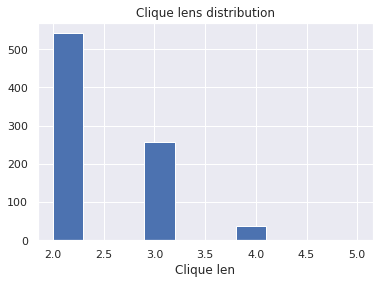

In [5]:
plt.hist(lens)
plt.title("Clique lens distribution")
plt.xlabel("Clique len");

In [32]:
[(uG.nodes[node]["name"], uG.nodes[node]["company"]) for node in max_cl[0]]

[('sergey zakharov', 'x5'),
 ('Mikhail Chesnokov', 'undefined'),
 ('Valentin Malykh', 'undefined'),
 ('Михаил Плеханов', 'fb'),
 ('Artur Kuzin', 'x5')]

In [63]:
def largest_cliques(G):
    G = nx.convert_node_labels_to_integers(G)
    lens = [len(x) for x in nx.find_cliques(G)]
    max_cl = [x for x in nx.find_cliques(G) if len(x) == max(lens)]
    colors = np.ones((len(max_cl), len(G.nodes), 3))
    for i, cl in enumerate(max_cl):
        colors[i, cl] = [1, 0, 0]

    width = np.ones((len(max_cl), len(G.edges)))
    for i, cl in enumerate(max_cl):
        for j, edge in enumerate(G.edges):
            if edge[0] in cl and edge[1] in cl:
                width[i, j] = 1.5

    return (colors, width)

In [64]:
colors, widths = largest_cliques(uG)
layout = nx.kamada_kawai_layout(uG)

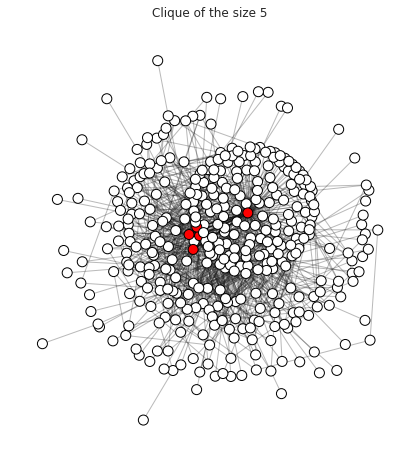

In [66]:
plt.figure(figsize=(8 * 2, 8))

for i in range(colors.shape[0]):

    b_edges = np.array(list(uG.edges))[widths[i] == widths[i].max()]

    plt.subplot(1, 2, i + 1)
    nodes = nx.draw_networkx_nodes(uG, layout, node_color=colors[i], node_size=100, linewidths=1, edgecolors="black")
    nx.draw_networkx_edges(uG, layout, alpha=0.3, width=widths[i].min())
    nx.draw_networkx_edges(uG, layout, width=widths[i].max(), edgelist=b_edges)
    plt.title("Clique of the size {}".format(max(lens)))
    plt.axis("off")

Клика включает в себя Sergey Zakharov, Mikhail Chesnokov, Valentin Malykh - это топ ноды по центральностям

In [35]:
def k_core_decompose(G):
    return np.array(list(nx.core_number(G).values()))

In [40]:
labels = k_core_decompose(uG)

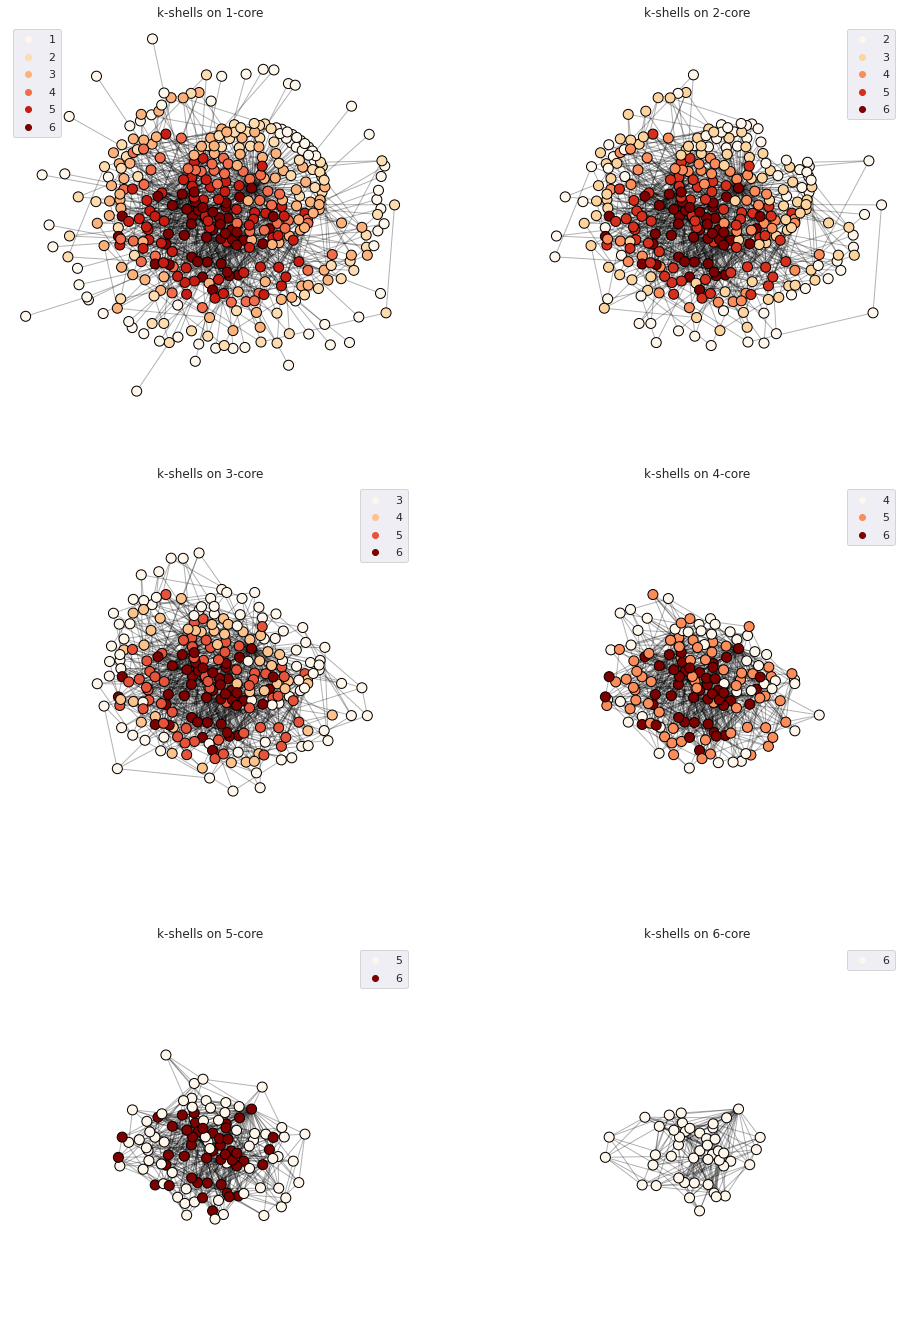

In [51]:
plt.figure(figsize=(8 * 2, 6 * 4))

x_max, y_max = np.array(list(layout.values())).max(axis=0)
x_min, y_min = np.array(list(layout.values())).min(axis=0)

for i in range(6):
    plt.subplot(3, 2, i + 1)
    subG = nx.k_core(uG, i + 1)
    nodes = nx.draw_networkx_nodes(
        subG, layout, cmap=plt.cm.OrRd, node_color=k_core_decompose(subG), node_size=100, edgecolors="black"
    )
    nx.draw_networkx_edges(subG, layout, alpha=0.3, width=1, edge_color="black")
    eps = (x_max - x_min) * 0.05
    plt.xlim(x_min - eps, x_max + eps)
    plt.ylim(y_min - eps, y_max + eps)
    plt.legend(*nodes.legend_elements())
    plt.axis("off")
    plt.title("k-shells on {}-core".format(i + 1))

Требуется небольшое количество шагов, чтобы осталась только одна связная компнента (ноды достаточно плотно связаны между собой)

## Results of various community detection algorithms

### Agglomerative clustering

In [67]:
def simrank_distance(G):
    return 1 - np.array([list(x.values()) for x in list(nx.simrank_similarity(G).values())]).round(12)

In [68]:
distance = simrank_distance(uG)

In [75]:
distance.max()

0.958917207045

In [69]:
def agglomerative_clustering(distance, max_distance):
    clus = AgglomerativeClustering(
        n_clusters=None, affinity="precomputed", linkage="complete", distance_threshold=max_distance
    )
    return clus.fit_predict(distance)

In [218]:
top_companies = [
    "sberbank",
    "raiffeisen",
    "ozon",
    "alfabank",
    "rt",
    "2a2i",
    "samsung",
    "tinkoff",
    "ostrovok",
    "x5",
    "beeline",
    "huawei",
    "open",
    "sportmaster",
    "sbdagroup",
    "avito",
]

In [219]:
companies = [
    uG.nodes[node]["company"] if uG.nodes[node]["company"] in top_companies else "undefined" for node in uG.nodes
]
mapping = {val: i for i, val in enumerate(np.unique(companies))}
ground_truth = [mapping[l] for l in companies]
X = [list(x[1].values()) for x in nx.shortest_path_length(uG)]

In [220]:
def get_stats(labels):
    communities = [set(np.array(uG.nodes)[labels == l]) for l in np.unique(labels)]
    qdf = pd.DataFrame({"ground_truth": ground_truth, "labels": labels})
    return (
        f"modularity {round(modularity(uG, communities), 4)}, "
        + f"silhouette {round(silhouette_score(X, labels), 4)}, "
        + f"ground truth score {round(adjusted_rand_score(ground_truth, labels), 4)}"
    )

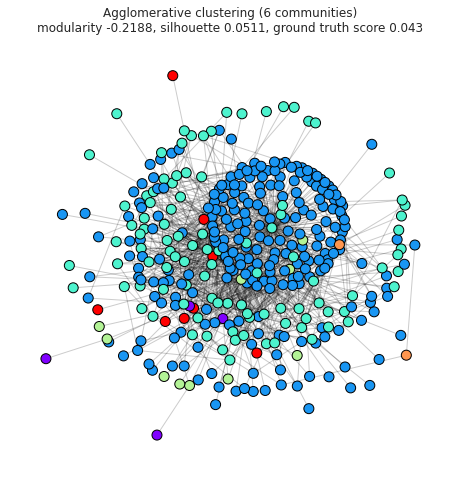

In [221]:
labels = agglomerative_clustering(distance, 0.95)
plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(
    uG, layout, cmap=plt.cm.rainbow, node_color=labels, node_size=100, linewidths=1, edgecolors="black"
)
nx.draw_networkx_edges(uG, layout, alpha=0.2, edge_color="black")
plt.axis("off")
plt.title(f"Agglomerative clustering ({len(np.unique(labels))} communities)\n{get_stats(labels)}")
plt.show()

### Girvan-Newman algorithm

In [226]:
def girvan_newman(G, n):
    G = nx.convert_node_labels_to_integers(G)
    labels = np.zeros((n, len(G)))
    _G = G.copy()
    for division in range(n):
        remove_bridges(_G)
        for i, cc in enumerate(nx.connected_components(_G)):
            labels[division, list(cc)] = i
    return labels

In [227]:
def remove_bridges(G):
    n_cc = nx.number_connected_components(G)
    while nx.number_connected_components(G) == n_cc:
        ebetweenness = nx.edge_betweenness_centrality(G)
        G.remove_edge(*max(ebetweenness, key=ebetweenness.get))

In [228]:
labels = girvan_newman(uG, 42)

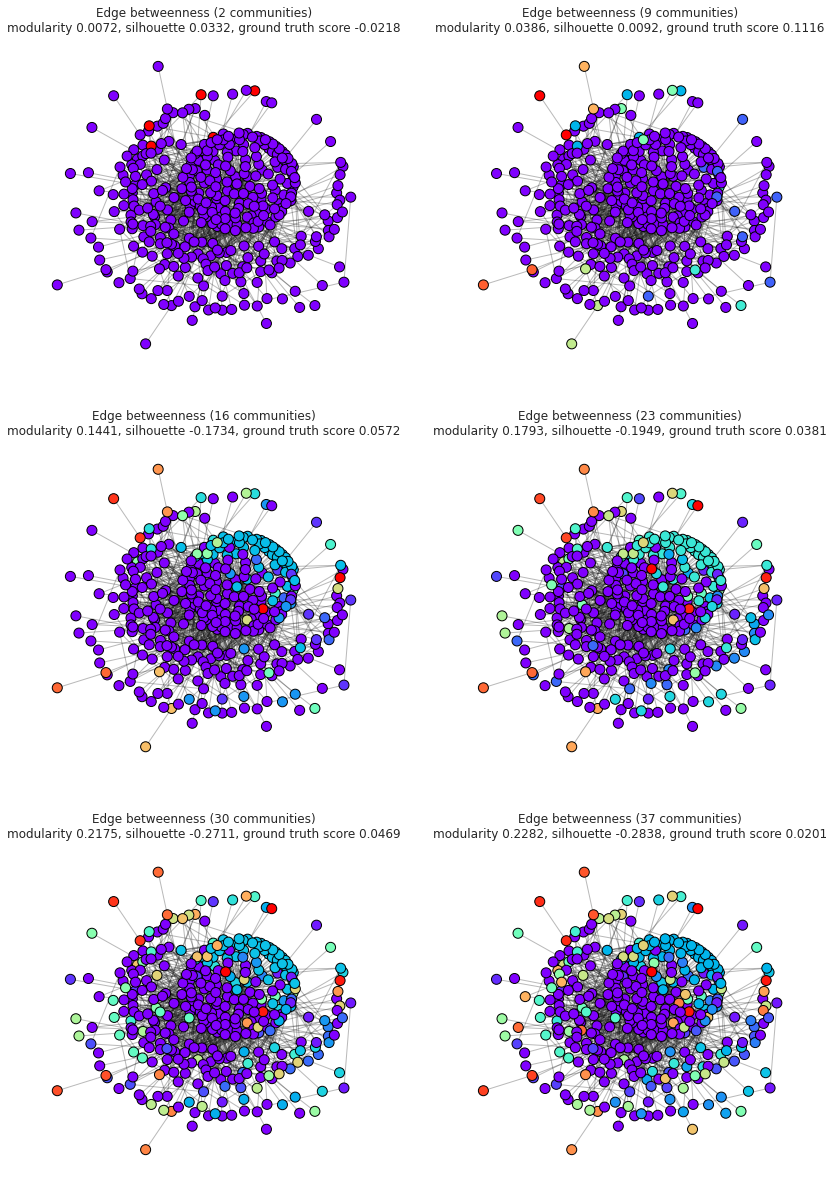

In [229]:
plt.figure(figsize=(7 * 2, 7 * 3))
for i in range(6):
    plt.subplot(3, 2, i + 1)
    nx.draw_networkx_nodes(uG, layout, cmap=plt.cm.rainbow, node_color=labels[i * 7], node_size=100, edgecolors="black")
    nx.draw_networkx_edges(uG, layout, alpha=0.3)
    plt.title(f"Edge betweenness ({len(np.unique(labels[i*7]))} communities)\n{get_stats(labels[i*7])}")
    plt.axis("off")

### Label propagation for clustering

In [222]:
def sync_update_labels(graph, labels):
    new_labels = []
    A = nx.to_numpy_array(graph)
    for node in graph.nodes:
        nei_labels = list(np.random.permutation(labels[A[node] == 1]))
        new_labels.append(max(OrderedDict.fromkeys(nei_labels), key=nei_labels.count))
    return np.array(new_labels)

In [223]:
def plot_propagation(G, update_method, n=50):
    G = nx.convert_node_labels_to_integers(G)
    pos = nx.kamada_kawai_layout(G)
    labels = np.array(list(G.nodes))
    for i in range(n):
        clear_output(wait=True)
        labels = update_method(G, labels)
        plt.figure(figsize=(8, 8))
        nx.draw_networkx_nodes(G, pos=pos, node_color=labels, cmap=plt.cm.rainbow, node_size=100, edgecolors="black")
        nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
        plt.axis("off")
        plt.title(f"Iteration {i+1}/{n}\nEdge betweenness ({len(np.unique(labels))} communities)\n{get_stats(labels)}")
        plt.show()

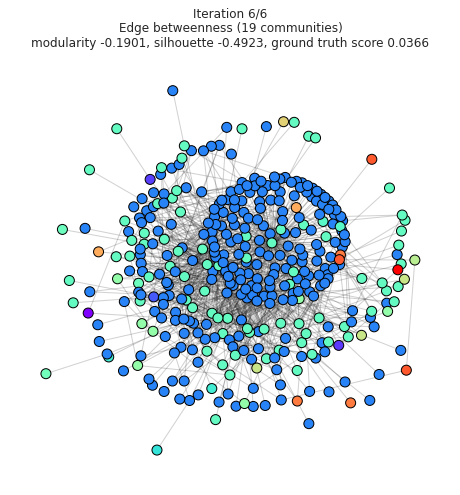

In [225]:
plot_propagation(uG, sync_update_labels, 6)

Результаты кластеризации получились не очень качественными - это можно быть связано с тем, что все ноды плотно связаны между собой и связи между сотрудниками одной компании не очень тесные. Это означает, что в графе нет четко выделенных сообществ, которые ставят реакции только друг другу

Возможно, данный результат можно улучшить, получив из описания вакансии ее направление (nlp, de, mlops, cv ..) и анализируя кластеризацию по профессиональному направлению участника.

Наилучший результат получился для Girvan-Newman algorithm (последовательное удаление связывающих ребер постепенно делает граф менее разреженным). Agglomerative clustering напротив последовательно объединяет мелкие кластеры. Label propagation очень быстро окрашивает все ноды в один цвет, поскольку граф плотный